# Softmax exercise

*Complete and hand in this completed worksheet (including its outputs and any supporting code outside of the worksheet) with your assignment submission. For more details see the [assignments page](http://vision.stanford.edu/teaching/cs231n/assignments.html) on the course website.*

This exercise is analogous to the SVM exercise. You will:

- implement a fully-vectorized **loss function** for the Softmax classifier
- implement the fully-vectorized expression for its **analytic gradient**
- **check your implementation** with numerical gradient
- use a validation set to **tune the learning rate and regularization** strength
- **optimize** the loss function with **SGD**
- **visualize** the final learned weights


In [20]:
import random
import numpy as np
from cs231n.data_utils import load_CIFAR10
import matplotlib.pyplot as plt

%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# for auto-reloading extenrnal modules
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [21]:
def get_CIFAR10_data(num_training=49000, num_validation=1000, num_test=1000, num_dev=500):
    """
    Load the CIFAR-10 dataset from disk and perform preprocessing to prepare
    it for the linear classifier. These are the same steps as we used for the
    SVM, but condensed to a single function.  
    """
    # Load the raw CIFAR-10 data
    cifar10_dir = 'cs231n/datasets/cifar-10-batches-py'
    
    # Cleaning up variables to prevent loading data multiple times (which may cause memory issue)
    try:
       del X_train, y_train
       del X_test, y_test
       print('Clear previously loaded data.')
    except:
       pass

    X_train, y_train, X_test, y_test = load_CIFAR10(cifar10_dir)
    
    # subsample the data
    mask = list(range(num_training, num_training + num_validation))
    X_val = X_train[mask]
    y_val = y_train[mask]
    mask = list(range(num_training))
    X_train = X_train[mask]
    y_train = y_train[mask]
    mask = list(range(num_test))
    X_test = X_test[mask]
    y_test = y_test[mask]
    mask = np.random.choice(num_training, num_dev, replace=False)
    X_dev = X_train[mask]
    y_dev = y_train[mask]
    
    # Preprocessing: reshape the image data into rows
    X_train = np.reshape(X_train, (X_train.shape[0], -1))
    X_val = np.reshape(X_val, (X_val.shape[0], -1))
    X_test = np.reshape(X_test, (X_test.shape[0], -1))
    X_dev = np.reshape(X_dev, (X_dev.shape[0], -1))
    
    # Normalize the data: subtract the mean image
    mean_image = np.mean(X_train, axis = 0)
    X_train -= mean_image
    X_val -= mean_image
    X_test -= mean_image
    X_dev -= mean_image
    
    # add bias dimension and transform into columns
    X_train = np.hstack([X_train, np.ones((X_train.shape[0], 1))])
    X_val = np.hstack([X_val, np.ones((X_val.shape[0], 1))])
    X_test = np.hstack([X_test, np.ones((X_test.shape[0], 1))])
    X_dev = np.hstack([X_dev, np.ones((X_dev.shape[0], 1))])
    
    return X_train, y_train, X_val, y_val, X_test, y_test, X_dev, y_dev


# Invoke the above function to get our data.
X_train, y_train, X_val, y_val, X_test, y_test, X_dev, y_dev = get_CIFAR10_data()
print('Train data shape: ', X_train.shape)
print('Train labels shape: ', y_train.shape)
print('Validation data shape: ', X_val.shape)
print('Validation labels shape: ', y_val.shape)
print('Test data shape: ', X_test.shape)
print('Test labels shape: ', y_test.shape)
print('dev data shape: ', X_dev.shape)
print('dev labels shape: ', y_dev.shape)

Train data shape:  (49000, 3073)
Train labels shape:  (49000,)
Validation data shape:  (1000, 3073)
Validation labels shape:  (1000,)
Test data shape:  (1000, 3073)
Test labels shape:  (1000,)
dev data shape:  (500, 3073)
dev labels shape:  (500,)


## Softmax Classifier

Your code for this section will all be written inside `cs231n/classifiers/softmax.py`.


In [22]:
# First implement the naive softmax loss function with nested loops.
# Open the file cs231n/classifiers/softmax.py and implement the
# softmax_loss_naive function.

from cs231n.classifiers.softmax import softmax_loss_naive
import time

# Generate a random softmax weight matrix and use it to compute the loss.
W = np.random.randn(3073, 10) * 0.0001
loss, grad = softmax_loss_naive(W, X_dev, y_dev, 0.0)

# As a rough sanity check, our loss should be something close to -log(0.1).
print('loss: %f' % loss)
print('sanity check: %f' % (-np.log(0.1)))

loss: 2.391878
sanity check: 2.302585


**Inline Question 1**

Why do we expect our loss to be close to -log(0.1)? Explain briefly.**

$\color{blue}{\textit Your Answer:}$ *Fill this in* 



In [25]:
# Complete the implementation of softmax_loss_naive and implement a (naive)
# version of the gradient that uses nested loops.
loss, grad = softmax_loss_naive(W, X_dev, y_dev, 0.0)

# As we did for the SVM, use numeric gradient checking as a debugging tool.
# The numeric gradient should be close to the analytic gradient.
from cs231n.gradient_check import grad_check_sparse
f = lambda w: softmax_loss_naive(w, X_dev, y_dev, 0.0)[0]
grad_numerical = grad_check_sparse(f, W, grad, 10)

# similar to SVM case, do another gradient check with regularization
loss, grad = softmax_loss_naive(W, X_dev, y_dev, 5e1)
f = lambda w: softmax_loss_naive(w, X_dev, y_dev, 5e1)[0]
grad_numerical = grad_check_sparse(f, W, grad, 10)

numerical: -0.423867 analytic: -0.423867, relative error: 1.065403e-08
numerical: 1.485200 analytic: 1.485200, relative error: 1.547225e-08
numerical: -1.129306 analytic: -1.129306, relative error: 3.932083e-09
numerical: -0.985115 analytic: -0.985115, relative error: 3.745997e-08
numerical: 0.466309 analytic: 0.466309, relative error: 7.568924e-08
numerical: 1.114335 analytic: 1.114335, relative error: 4.688957e-09
numerical: -2.749748 analytic: -2.749748, relative error: 1.189393e-08
numerical: -2.678000 analytic: -2.678000, relative error: 1.241435e-08
numerical: 3.334628 analytic: 3.334628, relative error: 8.401045e-09
numerical: 1.902585 analytic: 1.902584, relative error: 3.822146e-08
numerical: 2.842660 analytic: 2.842660, relative error: 7.997239e-09
numerical: 3.720150 analytic: 3.720150, relative error: 3.120896e-08
numerical: 0.930213 analytic: 0.930213, relative error: 1.256853e-08
numerical: -0.346613 analytic: -0.346614, relative error: 1.573823e-07
numerical: 3.032550 an

In [26]:
# Now that we have a naive implementation of the softmax loss function and its gradient,
# implement a vectorized version in softmax_loss_vectorized.
# The two versions should compute the same results, but the vectorized version should be
# much faster.
tic = time.time()
loss_naive, grad_naive = softmax_loss_naive(W, X_dev, y_dev, 0.000005)
toc = time.time()
print('naive loss: %e computed in %fs' % (loss_naive, toc - tic))

from cs231n.classifiers.softmax import softmax_loss_vectorized
tic = time.time()
loss_vectorized, grad_vectorized = softmax_loss_vectorized(W, X_dev, y_dev, 0.000005)
toc = time.time()
print('vectorized loss: %e computed in %fs' % (loss_vectorized, toc - tic))

# As we did for the SVM, we use the Frobenius norm to compare the two versions
# of the gradient.
grad_difference = np.linalg.norm(grad_naive - grad_vectorized, ord='fro')
print('Loss difference: %f' % np.abs(loss_naive - loss_vectorized))
print('Gradient difference: %f' % grad_difference)

naive loss: 2.391878e+00 computed in 0.118333s
vectorized loss: 2.391878e+00 computed in 0.004651s
Loss difference: 0.000000
Gradient difference: 0.000000


In [30]:
# Use the validation set to tune hyperparameters (regularization strength and
# learning rate). You should experiment with different ranges for the learning
# rates and regularization strengths; if you are careful you should be able to
# get a classification accuracy of over 0.35 on the validation set.

from cs231n.classifiers import Softmax
results = {}
best_val = -1
best_softmax = None

################################################################################
# TODO:                                                                        #
# Use the validation set to set the learning rate and regularization strength. #
# This should be identical to the validation that you did for the SVM; save    #
# the best trained softmax classifer in best_softmax.                          #
################################################################################

# *****START OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****

# Provided as a reference. You may or may not want to change these hyperparameters
learning_rates = np.logspace(-6.8, -6.0, num=5)
regularization_strengths = np.logspace(3, 5, num=5)
# [5.011872e-07] # 
# *****START OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****

from cs231n.classifiers import Softmax

for regularization_strength in regularization_strengths:
    for learning_rate in learning_rates:
        softmax = Softmax()        
        print("lr ", learning_rate, " reg ", regularization_strength)
        loss_hist = softmax.train(X_train, y_train, learning_rate=learning_rate, reg=regularization_strength,
                            num_iters=3000, verbose=True)
        
        y_train_pred = softmax.predict(X_train)
        training_accuracy = np.mean(y_train == y_train_pred)
        print('training accuracy: %f' % training_accuracy, )

        y_val_pred = softmax.predict(X_val)
        validation_accuracy = np.mean(y_val == y_val_pred)
        print('validation accuracy: %f' % validation_accuracy, )
        results[(learning_rate, regularization_strength)] = (training_accuracy, validation_accuracy)

        if validation_accuracy > best_val:
            best_val = validation_accuracy
            best_softmax = softmax

# *****END OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****
    
# Print out results.
for lr, reg in sorted(results):
    train_accuracy, val_accuracy = results[(lr, reg)]
    print('lr %e reg %e train accuracy: %f val accuracy: %f' % (
                lr, reg, train_accuracy, val_accuracy))
    
print('best validation accuracy achieved during cross-validation: %f' % best_val)

lr  1.584893192461114e-07  reg  1000.0
iteration 0 / 3000: loss 36.381146
iteration 100 / 3000: loss 33.224311
iteration 200 / 3000: loss 31.966727
iteration 300 / 3000: loss 30.627460
iteration 400 / 3000: loss 29.348887
iteration 500 / 3000: loss 28.353658
iteration 600 / 3000: loss 27.470023
iteration 700 / 3000: loss 26.321226
iteration 800 / 3000: loss 25.364254
iteration 900 / 3000: loss 24.872490
iteration 1000 / 3000: loss 24.021087
iteration 1100 / 3000: loss 23.140158
iteration 1200 / 3000: loss 22.793218
iteration 1300 / 3000: loss 21.810317
iteration 1400 / 3000: loss 21.138072
iteration 1500 / 3000: loss 20.708787
iteration 1600 / 3000: loss 20.083200
iteration 1700 / 3000: loss 19.351717
iteration 1800 / 3000: loss 18.977671
iteration 1900 / 3000: loss 18.171040
iteration 2000 / 3000: loss 17.645083
iteration 2100 / 3000: loss 17.314594
iteration 2200 / 3000: loss 16.758037
iteration 2300 / 3000: loss 15.963942
iteration 2400 / 3000: loss 15.842477
iteration 2500 / 3000: 

In [31]:
# evaluate on test set
# Evaluate the best softmax on test set
y_test_pred = best_softmax.predict(X_test)
test_accuracy = np.mean(y_test == y_test_pred)
print('softmax on raw pixels final test set accuracy: %f' % (test_accuracy, ))

softmax on raw pixels final test set accuracy: 0.397000


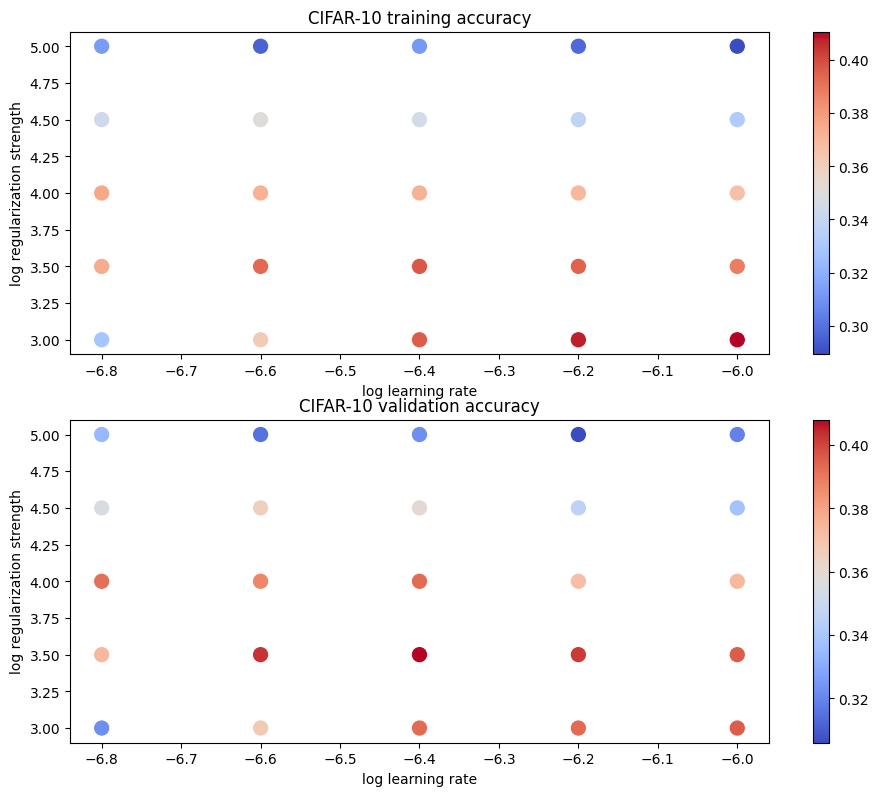

In [32]:
# Visualize the cross-validation results
import math
import pdb

# pdb.set_trace()

x_scatter = [math.log10(x[0]) for x in results]
y_scatter = [math.log10(x[1]) for x in results]

# plot training accuracy
marker_size = 100
colors = [results[x][0] for x in results]
plt.subplot(2, 1, 1)
plt.tight_layout(pad=3)
plt.scatter(x_scatter, y_scatter, marker_size, c=colors, cmap=plt.cm.coolwarm)
plt.colorbar()
plt.xlabel('log learning rate')
plt.ylabel('log regularization strength')
plt.title('CIFAR-10 training accuracy')

# plot validation accuracy
colors = [results[x][1] for x in results] # default size of markers is 20
plt.subplot(2, 1, 2)
plt.scatter(x_scatter, y_scatter, marker_size, c=colors, cmap=plt.cm.coolwarm)
plt.colorbar()
plt.xlabel('log learning rate')
plt.ylabel('log regularization strength')
plt.title('CIFAR-10 validation accuracy')
plt.show()

**Inline Question 2** - *True or False*

Suppose the overall training loss is defined as the sum of the per-datapoint loss over all training examples. It is possible to add a new datapoint to a training set that would leave the SVM loss unchanged, but this is not the case with the Softmax classifier loss.

$\color{blue}{\textit Your Answer:}$
1] As long as the SVM loss of the new datapoint is zero, the SVM loss would be unaffected. This would be the case if its incorrect classes satisfy the margin, i.e., the scores of the incorrect class is below the score of the correct class by atleast delta. Assume the following: (i) the delta for SVM is 1, (ii) the correct class is #0 and, (iii) we add a new datapoint #3 that leads to scores [3,1,2], then the SVM loss for the new datapoint will be 0 (and the overall SVM loss would be unchanged) because it is below the score of the correct class by atleast delta, i.e., max(0, 1 - 3 + 1) + max(0, 2 - 3 + 1) = 0.

Unlike SVM, the Softmax classifier will assume a larger loss because the addition of a new datapoint will ultimately reduce the score of the correct class after normalization which would affect the loss negatively (i.e., lesser the score of the correct class, more the loss). This is because the Softmax classifier considers all the individual scores in the calculation of its loss while the SVM loss does not take into account the individual scores as long as the incorrect classes have scores that are below that of the correct class by atleast delta. Put differently, how far below the scores of the incorrect classes are compared to that of the correct class (as long as they are atleast delta apart) is not a point of consideration for SVM, unlike Softmax.

$\color{blue}{\textit Your Explanation:}$



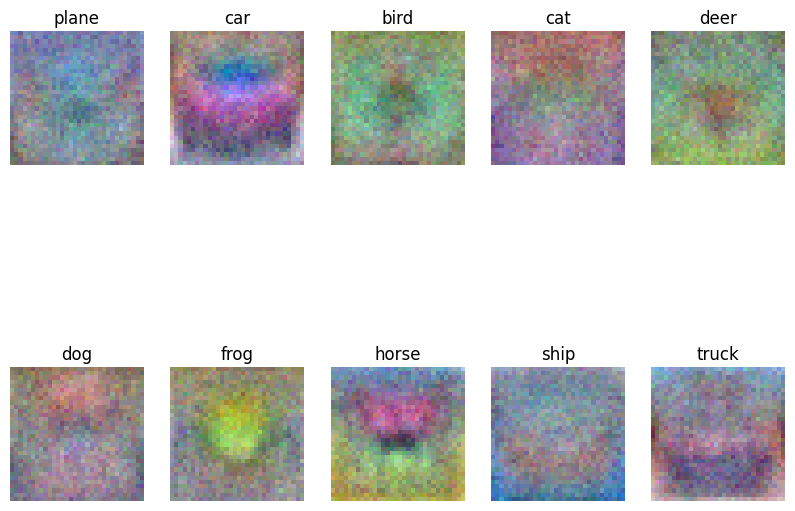

In [35]:
# Visualize the learned weights for each class
w = best_softmax.W[:-1,:] # strip out the bias
w = w.reshape(32, 32, 3, 10)

w_min, w_max = np.min(w), np.max(w)

classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
for i in range(10):
    plt.subplot(2, 5, i + 1)
    
    # Rescale the weights to be between 0 and 255
    wimg = 255.0 * (w[:, :, :, i].squeeze() - w_min) / (w_max - w_min)
    plt.imshow(wimg.astype('uint8'))
    plt.axis('off')
    plt.title(classes[i])